In [1]:
#@title Define if we are on Colab and mount drive { display-mode: "form" }
run_params = {}
try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  run_params['IN_COLAB'] = True
except:
  run_params['IN_COLAB'] = False

Mounted at /content/gdrive


In [2]:
#@title (COLAB ONLY) Clone GitHub repo { display-mode: "form" }

if run_params['IN_COLAB']:
  !git clone https://github.com/lluissalord/radiology_ai.git

  %cd radiology_ai

Cloning into 'radiology_ai'...
remote: Enumerating objects: 562, done.
remote: Counting objects: 100% (562/562), done.
remote: Compressing objects: 100% (331/331), done.
remote: Total 1094 (delta 347), reused 429 (delta 229), pack-reused 532
Receiving objects: 100% (1094/1094), 56.29 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (678/678), done.
/content/radiology_ai


In [3]:
#@title Setup environment and Colab general variables { display-mode: "form" }
# %%capture
%run colab_setup.ipynb

env: PYTHONPATH=
--2021-01-24 14:21:54--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2021-01-24 14:21:54--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94235922 (90M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  89.87M   183MB/s    in 0.5s    

2021-01-24 14:21:54 (183 MB/s) - ‘Minico

In [4]:
#@title Move images from Drive to temporary folder here to be able to train models { display-mode: "form" }
# %%capture
%run move_raw_preprocess.ipynb

In [5]:
import os

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from fastai.basics import *
from fastai.callback.all import *
from fastai.data.block import *
from fastai.data.transforms import *
from fastai.vision import models
from fastai.vision.learner import *
from fastai.vision.augment import *
from fastai.vision.core import PILImageBW, PILImage
from fastai.vision.data import *

In [6]:
run_params['SELF_SUPERVISED'] = False

if run_params['SELF_SUPERVISED']:
    import pl_bolts
    from pl_bolts.models.self_supervised import SimCLR
    from pl_bolts.models.self_supervised.simclr import SimCLRTrainDataTransform, SimCLREvalDataTransform
    from pytorch_lightning import Trainer

In [7]:
from preprocessing.transforms import *
# from preprocessing.dicom import *
from preprocessing.misc import *

from utils.models import *
from utils.organize import *
from utils.misc import *
from utils.data import *

In [8]:
run_params['SSL_MIX_MATCH'] = 'MixMatch'
run_params['SSL_FIX_MATCH'] = 'FixMatch'

run_params['SSL'] = run_params['SSL_FIX_MATCH']
# run_params['SSL'] = None

if run_params['SSL'] == run_params['SSL_FIX_MATCH']:
    from semisupervised.fixmatch.losses import FixMatchLoss as SSLLoss
    from semisupervised.fixmatch.callback import FixMatchCallback as SSLCallback
elif run_params['SSL'] == run_params['SSL_MIX_MATCH']:
    from semisupervised.mixmatch.losses import MixMatchLoss as SSLLoss
    from semisupervised.mixmatch.callback import MixMatchCallback as SSLCallback

In [9]:
run_params['TEST_SIZE'] = 0.15
run_params['VALID_SIZE'] = 0.15

In [31]:
# Hyperparameters

run_params['HIST_CLIPPING'] = True
run_params['HIST_CLIPPING_CUT_MIN'] = 5.
run_params['HIST_CLIPPING_CUT_MAX'] = 99.

run_params['KNEE_LOCALIZER'] = True
run_params['CLAHE_SCALED'] = True
run_params['HIST_SCALED'] = False
run_params['HIST_SCALED_SELF'] = True

run_params['BINARY_CLASSIFICATION'] = True

run_params['CLASS_WEIGHT'] = True
run_params['WEIGTHED_SAMPLER'] = False
run_params['ALL_LABELS_IN_BATCH'] = True
run_params['MIN_SAMPLES_PER_LABEL'] = 1

run_params['LR'] = 0.0005
run_params['GRAD_CLIP_VAL'] = 1 # None

run_params['RESIZE'] = 384
run_params['RANDOM_RESIZE_CROP'] = 256
run_params['RANDOM_MIN_SCALE'] = 0.5

run_params['SELF_SUPERVISED_BATCH_SIZE'] = 64

if run_params['SSL']:
    if run_params['SSL'] == run_params['SSL_FIX_MATCH']:
        run_params['BATCH_SIZE'] = 8
        run_params['MOMENTUM'] = 0.9
        run_params['WD'] = 0.0005
        run_params['LAMBDA_U'] = 1
        run_params['MU'] = 5
        run_params['LABEL_THRESHOLD'] = 0.95

        cb_params = {}

        loss_params = {
            'bs': run_params['BATCH_SIZE'],
            'mu': run_params['MU'],
            'lambda_u': run_params['LAMBDA_U'],
            'label_threshold': run_params['LABEL_THRESHOLD']
        }
    elif run_params['SSL'] == run_params['SSL_MIX_MATCH']:
        run_params['BATCH_SIZE'] = 16
        run_params['LAMBDA_U'] = 75
        run_params['T'] = 0.5
        run_params['ALPHA'] = 0.75

        cb_params = {
            'T': run_params['T']
        }

        loss_params = {
            'bs': run_params['BATCH_SIZE'],
            'lambda_u': run_params['LAMBDA_U'],
        }

    loss_params['use_SCL'] = True
    loss_params['beta'] = 0.5

    run_params['EMA_DECAY'] = 0.999
else:
    run_params['BATCH_SIZE'] = 32


run_params['USE_SAVED_MODEL'] = True
run_params['SAVE_MODEL'] = False

run_params['MODEL'] = models.resnet18
run_params['MODEL'] = models.squeezenet1_0
# MODEL = 'efficientnet-b0'
run_params['MODEL_VERSION'] = 0
run_params['MODEL_DESCRIPTION'] = f'{"SSL_" if run_params["SSL"] else ""}{"SELFSUP_" if run_params["SELF_SUPERVISED"] else ""}sz{min(run_params["RESIZE"], run_params["RANDOM_RESIZE_CROP"])}'
run_params['MODEL_SAVE_NAME'] = f'{run_params["MODEL"].__name__}_{run_params["MODEL_DESCRIPTION"]}_v{run_params["MODEL_VERSION"]}.pkl'
run_params['MODEL_SAVE_PATH'] = os.path.join(run_params['MODELS_FOLDER'], run_params['MODEL_SAVE_NAME'])

run_params['PRETRAINED_MODEL_SAVE_NAME'] = 'resnet18_v0.pkl'
run_params['PRETRAINED_MODEL_SAVE_NAME'] = os.path.join(run_params['MODELS_FOLDER'], run_params['PRETRAINED_MODEL_SAVE_NAME'])
if run_params['USE_SAVED_MODEL'] and not os.path.exists(run_params['PRETRAINED_MODEL_SAVE_NAME']):
    print(f'Not using pretrained model as there is no model on: {run_params["PRETRAINED_MODEL_SAVE_NAME"]}')
    run_params['USE_SAVED_MODEL'] = False

In [11]:
run_params['SEED'] = 42

seed_everything(run_params['SEED'])

Using seed: 42


42

In [12]:
# Transformations

item_tfms = []

if run_params['HIST_CLIPPING']:
    item_tfms.append(XRayPreprocess(PIL_cls=PILImageBW, cut_min=run_params['HIST_CLIPPING_CUT_MIN'], cut_max=run_params['HIST_CLIPPING_CUT_MAX'], np_input=len(item_tfms) > 0, np_output=True))

if run_params['KNEE_LOCALIZER']:
    item_tfms.append(KneeLocalizer(run_params['KNEE_SVM_MODEL_PATH'], PIL_cls=PILImageBW, resize=run_params['RESIZE'], np_input=len(item_tfms) > 0, np_output=True))
else:
    item_tfms.append(Resize(run_params['RESIZE'], method=ResizeMethod.Pad, pad_mode=PadMode.Zeros))

# item_tfms.append(RandomResizedCrop(RANDOM_RESIZE_CROP))

label_transform = [
    # Flip(),
    *aug_transforms(
        pad_mode=PadMode.Zeros,
    ),
    RandomResizedCropGPU(run_params['RANDOM_RESIZE_CROP'], min_scale=run_params['RANDOM_MIN_SCALE']),
    Normalize()
]

unlabel_batch_tfms = [None]
if run_params['SSL'] == run_params['SSL_FIX_MATCH']:

    weak_transform = [
        RandomResizedCropGPU(run_params['RANDOM_RESIZE_CROP']),
        Flip(),
        Normalize()
    ]
    unlabel_batch_tfms.append(weak_transform)

    strong_transform = [
        RandomResizedCropGPU(run_params['RANDOM_RESIZE_CROP']),
        Flip(),
        Rotate(90),
        Brightness(),
        Contrast(),
        RandomErasing(),
        Normalize()
    ]
    unlabel_batch_tfms.append(strong_transform)

elif run_params['SSL'] == run_params['SSL_MIX_MATCH']:

    unlabel_transform = [
        RandomResizedCropGPU(run_params['RANDOM_RESIZE_CROP']),
        Flip(),
        Rotate(180),
        Brightness(),
        Contrast(),
        Normalize()
    ]
    unlabel_batch_tfms.append(unlabel_transform)

In [13]:
# Callbacks
from fastai.callback.tensorboard import TensorBoardCallback
from fastai.callback import *

cbs = None
cbs = [
    TensorBoardCallback(projector=True),
]
if not run_params['SSL']:
    cbs = [
        MixUp()
    ]

In [14]:
if run_params['IN_COLAB']:
  df = concat_templates(run_params['ORGANIZE_FOLDER'], excel=True)
  df.to_excel(
      os.path.join(run_params['PATH_PREFIX'], 'all.xlsx'),
      index=False
  )
else:
  df = pd.read_excel(os.path.join(run_params['PATH_PREFIX'], 'all.xlsx'), dtype={'ID':'string','Target':'string'})

In [15]:
# Data

# Load DataFrame of relation between Original Filename and ID (IMG_XXX)
relation_df = pd.read_csv(os.path.join(run_params['PATH_PREFIX'], 'relation.csv'))
relation_df = relation_df.set_index('Filename')

# Merge data to be able to load directly from preprocessed PNG file
final_df = df.set_index('ID').merge(relation_df, left_index=True, right_index=True)
final_df['ID'] = final_df.index.values
final_df = final_df.reset_index(drop=True)
final_df['Raw_preprocess'] = final_df['Original_Filename'].apply(lambda filename: os.path.join(run_params['RAW_PREPROCESS_FOLDER'], filename + '.png'))

# Load DataFrame containing labels of OOS classifier ('ap', 'other')
metadata_labels_path = os.path.join(run_params['PATH_PREFIX'], 'metadata_labels.csv')
metadata_labels = pd.read_csv(metadata_labels_path)
metadata_labels = metadata_labels.set_index('Path')

# Merge all the data we have with the labelling in order to split correctly according to OOS classifier
unlabel_all_df = metadata_labels.merge(final_df.set_index('Raw_preprocess'), how='left', left_index=True, right_index=True)
unlabel_all_df = unlabel_all_df[unlabel_all_df.Target.isnull()]
unlabel_all_df['Raw_preprocess'] = unlabel_all_df.index.values

# Define which column to use as the prediction
if 'Final_pred' in unlabel_all_df.columns:
    pred_col = 'Final_pred'
else:
    pred_col = 'Pred'

# Conditions for AP radiographies on unlabel data
ap_match = (unlabel_all_df[pred_col] == 'ap') & (unlabel_all_df.Incorrect_image.isnull())

# Split between label_df (labelled data), `unlabel_df` (containing only AP) and `unlabel_other_df` (with the rest of unlabel data)
label_df = final_df[final_df['Target'].notnull()].reset_index(drop=True)
if run_params['BINARY_CLASSIFICATION']:
  label_df['Target'] = (label_df['Target'] != '0').astype(int).astype('string')
unlabel_df = unlabel_all_df[ap_match].reset_index(drop=True)
unlabel_other_df = unlabel_all_df[~ap_match].reset_index(drop=True)

print(f'Currently {len(label_df.index)} data have been labelled')
print(f'Remaining {len(unlabel_df.index)} data to be labelled')
print(f'Discarded {len(unlabel_other_df.index)} data')

# Split between train, valid and test
try:
  train_df, test_df = train_test_split(label_df, test_size=run_params['TEST_SIZE'], shuffle=True, stratify=label_df['Target'], random_state=run_params['SEED'])
except ValueError:
  train_df, test_df = train_test_split(label_df, test_size=run_params['TEST_SIZE'], shuffle=True, random_state=run_params['SEED'])

try:
  train_df, val_df = train_test_split(train_df, test_size=run_params['VALID_SIZE']/(1-run_params['TEST_SIZE']), shuffle=True, stratify=train_df['Target'], random_state=run_params['SEED'])
except ValueError:
  train_df, val_df = train_test_split(train_df, test_size=run_params['VALID_SIZE']/(1-run_params['TEST_SIZE']), shuffle=True, random_state=run_params['SEED'])

label_df.loc[train_df.index, 'Dataset'] = 'train'
label_df.loc[val_df.index, 'Dataset'] = 'valid'
label_df.loc[test_df.index, 'Dataset'] = 'test'

print('\nSplit of labelled data is:')
display(label_df['Dataset'].value_counts())

sort_dataset = {'train': 0, 'valid': 1, 'test': 2}
label_df = label_df.sort_values('Dataset', key=lambda x: x.map(sort_dataset)).reset_index(drop=True)

Currently 4144 data have been labelled
Remaining 11558 data to be labelled
Discarded 33074 data

Split of labelled data is:


train    2900
valid     622
test      622
Name: Dataset, dtype: int64

In [16]:
# Histogram scaling DICOM on the fly

if run_params['CLAHE_SCALED']:
    item_tfms.append(CLAHE_Transform(PIL_cls=PILImageBW, grayscale=not run_params['SELF_SUPERVISED'], np_input=len(item_tfms) > 0, np_output=False))
elif run_params['HIST_SCALED']:
    if run_params['HIST_SCALED_SELF']:
        bins = None
    else:
        # bins = init_bins(fnames=L(list(final_df['Original'].values)), n_samples=100)
        all_valid_raw_preprocess = pd.concat([pd.Series(unlabel_all_df.index), label_df['Raw_preprocess']])
        bins = init_bins(fnames=L(list(all_valid_raw_preprocess.values)), n_samples=100, isDCM=False)
    # item_tfms.append(HistScaled(bins))
    item_tfms.append(HistScaled_all(bins))

In [17]:
if run_params['SELF_SUPERVISED']:
    dataset = SelfSupervisedDataset(final_df, validation = False, transform = SimCLRTrainDataTransform(min(run_params['RESIZE'], run_params['RANDOM_RESIZE_CROP'])), prefix=run_params['RAW_PREPROCESS_FOLDER']+'/')
    val_dataset = SelfSupervisedDataset(final_df, validation = True, transform = SimCLREvalDataTransform(min(run_params['RESIZE'], run_params['RANDOM_RESIZE_CROP'])), prefix=run_params['RAW_PREPROCESS_FOLDER']+'/')

    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=run_params['SELF_SUPERVISED_BATCH_SIZE'],
                                              num_workers=0)

    val_loader = torch.utils.data.DataLoader(val_dataset,
                                              batch_size=run_params['SELF_SUPERVISED_BATCH_SIZE'],
                                              num_workers=0)
    num_samples = len(dataset)

    #init model with batch size, num_samples (len of data), epochs to train, and autofinds learning rate
    model_self_sup = SimCLR(gpus = 1, max_epochs=1, arch='resnet50', dataset='', batch_size = run_params['SELF_SUPERVISED_BATCH_SIZE'], num_samples = num_samples)

    trainer = Trainer(gpus = 1)
    try:
      trainer.fit(model_self_sup, data_loader, val_loader)
    except IndexError as e:
      print('Finish traininig due to IndexError: ', e)

In [18]:
## Define Dataset parameters

base_ds_params = {
    # 'get_x': ColReader('Original_Filename', pref=RAW_PREPROCESS_FOLDER+'/', suff='.png'),
    'get_x': ColReader('Raw_preprocess'),
    # 'get_x': ColReader('Original'),
    'item_tfms': item_tfms
}

# Specific parameters for Label Dataset 
label_ds_params = base_ds_params.copy()
if run_params['SELF_SUPERVISED']:
    label_ds_params['blocks'] = (ImageBlock(cls=PILImage), CategoryBlock)
else:
    label_ds_params['blocks'] = (ImageBlock(cls=PILImageBW), CategoryBlock)
# label_ds_params['blocks'] = (ImageBlock(cls=PILDicom_scaled), MultiCategoryBlock)

label_ds_params['get_y'] = ColReader('Target')
label_ds_params['splitter'] = TestColSplitter(col='Dataset')
label_ds_params['batch_tfms'] = label_transform


# Specific parameters for Unlabel Dataset
if run_params['SSL']:
    unlabel_ds_params = base_ds_params.copy()
    if run_params['SELF_SUPERVISED']:
        unlabel_ds_params['blocks'] = (ImageBlock(cls=PILImage))
    else:
        unlabel_ds_params['blocks'] = (ImageBlock(cls=PILImageBW))
    # unlabel_ds_params['blocks'] = (ImageBlock(cls=PILDicom_scaled))

    unlabel_ds_params['splitter'] = RandomSplitter(0)


## Define DataLoaders parameters
dls_params = {
    'bs': run_params['BATCH_SIZE'],
    'num_workers': 0,
    'shuffle_train': True,
    'drop_last': True
}

if run_params['SSL']:
    unlabel_dls_params = dls_params.copy()
    if run_params['SSL'] == run_params['SSL_FIX_MATCH']:
        unlabel_dls_params['bs'] = run_params['BATCH_SIZE'] * run_params['MU']

In [19]:
# DataLoaders
print(f'==> Preparing label dataloaders')

label_dl = DataBlock(**label_ds_params).dataloaders(label_df, **dls_params)

if run_params['ALL_LABELS_IN_BATCH']:
    # Create DataLoader which allows to have a minimum of samples of all the labels in each batch
    new_dl = DataBlock(**label_ds_params).dataloaders(label_df, **dls_params, dl_type=AllLabelsInBatchDL, min_samples=run_params['MIN_SAMPLES_PER_LABEL'])
    label_dl.train = new_dl.train

elif run_params['WEIGTHED_SAMPLER']:
    # Calculate sample weights to balance the DataLoader 
    from collections import Counter

    count = Counter(label_dl.items['Target'])
    class_weights = {}
    for c in count:
        class_weights[c] = 1/count[c]
    wgts = label_dl.items['Target'].map(class_weights).values[:len(train_df)]

    # Create weigthed dataloader
    weighted_dl = DataBlock(**label_ds_params).dataloaders(label_df, **dls_params, dl_type=WeightedDL, wgts=wgts)
    label_dl.train = weighted_dl.train

if run_params['SSL']:
    print(f'==> Preparing unlabel dataloaders')

    unlabel_dls = [
        DataBlock(
            **unlabel_ds_params,
            batch_tfms = batch_tfms
        ).dataloaders(unlabel_df, **unlabel_dls_params) 
        for batch_tfms in unlabel_batch_tfms
    ]
    print(f'==> Preparing SSL callback')

    ssl_cb = SSLCallback(*unlabel_dls, **cb_params)
    if cbs is None:
        cbs = [ssl_cb]
    else:
        cbs.append(ssl_cb)

    if run_params['SSL'] == run_params['SSL_MIX_MATCH']:
        cbs.append(MixUp(alpha=run_params['ALPHA']))

==> Preparing label dataloaders
==> Preparing unlabel dataloaders
==> Preparing SSL callback


In [41]:
# Scheduling
if run_params['SSL'] == run_params['SSL_FIX_MATCH']:
    sched = {'lr': SchedCos(run_params['LR'], run_params['LR']*math.cos(7*math.pi/16))}
    cbs.append(ParamScheduler(sched))
    opt_params = {
        'moms': (run_params['MOMENTUM'],)*3, # 0.9 according to FixMatch paper
        'wd': run_params['WD']
    }
    opt_func = SGD
else:
    opt_func = Adam
    opt_params = {}

In [21]:
# Model
# from fastai.vision.learner import create_head
from fastai.layers import *

print("==> creating model")

classes = label_df['Target'].unique()
n_out = len(classes)

if run_params['USE_SAVED_MODEL']:
    body = create_model(run_params['MODEL'], n_out, pretrained=True, n_in=1, bn_final=True)

    load_model(file=run_params['PRETRAINED_MODEL_SAVE_NAME'], model=body, opt=None, with_opt=False, device=torch.cuda.current_device(), strict=False)
    body = body[0]

    nf = num_features_model(nn.Sequential(*body.children())) * 2
    head = create_head(nf, n_out, concat_pool=True, bn_final=True)
        
    model = nn.Sequential(body, head)
    apply_init(model[1], nn.init.kaiming_normal_)

elif run_params['SELF_SUPERVISED']:
    concat_pool = True
    for i, layer_block in enumerate(model_self_sup.children()):
      if i == 1:
        for layer in layer_block.children():
          for j, layer_ in enumerate(layer.children()):
            if j == 3:
              nf = layer_.out_features
    # nf = num_features_model(nn.Sequential(*model_self_sup.children())) * (2 if concat_pool else 1)
    # head = create_head(nf, n_out, lin_ftrs=[512], ps=0.5, concat_pool=concat_pool, bn_final=True)

    # Seems there is somekind of issue and nf only can be 2048
    nf = 2048
    layers = [
        nn.Dropout(p=0.5),
        nn.Linear(nf, n_out),
        nn.BatchNorm1d(n_out, momentum=0.01)
    ]
    head = nn.Sequential(*layers)
    model = nn.Sequential(model_self_sup, head)
else:
    model = create_model(run_params['MODEL'], n_out, pretrained=True, n_in=1, bn_final=True)

# Initialize last BatchNorm bias with values reflecting the current probabilities with Softmax
with torch.no_grad():
    for name, param in model[-1][-1].named_parameters():
        if 'bias' in name:
            param.copy_(torch.as_tensor([np.log(p) for p in train_df['Target'].value_counts(normalize=True).values]))

if torch.cuda.is_available():
  model = model.cuda()

if run_params['SSL']:
  if run_params['SSL'] == run_params['SSL_MIX_MATCH']:
      loss_params['model'] = model

  cbs.append(EMAModel(alpha=run_params['EMA_DECAY']))

==> creating model


Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


In [22]:
if run_params['GRAD_CLIP_VAL'] is not None:
    cbs.append(GradientClipping(clip=run_params['GRAD_CLIP_VAL']))

In [23]:
# Loss
print("==> defining loss")

if run_params['CLASS_WEIGHT']:
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['Target'])
    class_weights /= class_weights.sum()
    
    # Correct the class weights in case of using AllLabelsInBatchDL
    if run_params['ALL_LABELS_IN_BATCH']:
        coef = run_params['MIN_SAMPLES_PER_LABEL'] * train_df['Target'].nunique() / run_params['BATCH_SIZE']
        class_weights *= 1 - coef
        class_weights += np.ones_like(class_weights) * coef / len(class_weights)

    class_weights = torch.as_tensor(class_weights).float()
    if torch.cuda.is_available():
        class_weights = class_weights.cuda()
else:
    class_weights = None

if run_params['SSL']:
    if loss_params['use_SCL']:
        loss_params['frequencies'] = torch.Tensor(train_df['Target'].value_counts())

    train_criterion = SSLLoss(unlabel_dl=unlabel_dls[0], n_out=n_out, weight=class_weights, **loss_params)
    criterion = train_criterion.Lx_criterion
else:
    train_criterion = None

==> defining loss


In [43]:
# Learner
print("==> defining learner")

if run_params['SSL']:
    Lx_metric = AvgMetric(func=criterion)
    Lu_metric = AvgMetric(func=train_criterion.Lu_criterion)

# Adapt metrics depending on the number of labels
if n_out == 2:
    average = 'binary'
    roc_auc = RocAucBinary()
else:
    average = 'macro'
    roc_auc = RocAuc()

metrics = [
    error_rate,
    BalancedAccuracy(),
    # roc_auc,
    FBeta(0.5, average=average),
    F1Score(average=average),
    FBeta(2, average=average),
    Precision(average=average),
    Recall(average=average)
]

learn = Learner(label_dl, model, loss_func=train_criterion, opt_func=opt_func, **opt_params, lr=run_params['LR'], metrics=metrics, cbs=cbs)
learn.recorder.train_metrics = True

==> defining learner


In [25]:
# learn.freeze()
# learn.lr_find()

In [26]:
# learn.unfreeze()
# learn.lr_find()

In [29]:
learn.fine_tune(10, run_params['LR'], freeze_epochs=3)

/usr/local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KeyboardInterrupt: ignored

In [44]:
learn.fine_tune(10, run_params['LR'], freeze_epochs=0)

/usr/local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
learn.fine_tune(10, run_params['LR'], freeze_epochs=0)

KeyboardInterrupt: ignored

In [ ]:
learn.fine_tune(10, run_params['LR'], freeze_epochs=0)

In [46]:
if run_params['SAVE_MODEL']:

    if not os.path.exists(run_params['MODELS_FOLDER']):
        os.makedirs(run_params['MODELS_FOLDER'])

    save_model(file=run_params['MODEL_SAVE_PATH'], model=learn.model, opt=learn.opt)

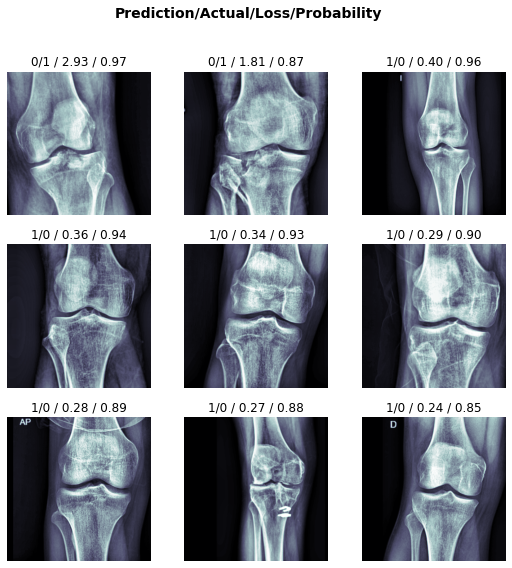

In [47]:
# Select only the top K images with largest loss

from fastai.interpret import ClassificationInterpretation
# from fastai2_extensions.interpret.all import *
# from fastai_amalgam.interpret.all import *

k = 9
largest = True
dls_idx = 1

preds, targs, decoded, all_losses = learn.get_preds(dls_idx, with_decoded=True, with_loss=True)
losses, idx = all_losses.topk(ifnone(k, len(all_losses)), largest=largest)

top_losses_dl = learn.dls.test_dl(learn.dls[dls_idx].items.iloc[idx])
top_losses_dl.bs = len(idx)

interp = ClassificationInterpretation(
    learn.dls[dls_idx],
    inputs=first(top_losses_dl),
    preds=preds[idx],
    targs=targs[idx],
    decoded=decoded[idx],
    losses=losses,
    # *tuple(map(lambda x: x[idx], learn.get_preds(dls_idx, with_input=True, with_loss=True, with_decoded=True)))
)
interp.plot_top_losses(k=k, cmap=plt.cm.bone)

In [48]:
dls_idx = 2

preds, targs, decoded, all_losses = learn.get_preds(dls_idx, with_decoded=True, with_loss=True)
max_preds, outs = torch.max(preds, axis=1)

for metric in metrics:
    try:
        metric_name = metric.name
    except AttributeError:
        metric_name = metric.__name__

    try:
        print(metric_name, ':', metric(preds, targs))
    except AssertionError:
        print(metric_name, ':', metric(outs, targs))

error_rate : tensor(0.0531)
balanced_accuracy_score : 0.7241935483870967
fbeta_score : 0.0373134328358209
f1_score : 0.05714285714285715
fbeta_score : 0.12195121951219512
precision_score : 0.030303030303030304
recall_score : 0.5


In [51]:
!pip install git+https://github.com/Synopsis/amalgam.git

  Cloning https://github.com/Synopsis/amalgam.git to /tmp/pip-req-build-7b0ad35w
  Created wheel for amalgam: filename=amalgam-0.0.26-py3-none-any.whl size=29591 sha256=78112b27500953397eb4b43cd04d413a7d0da7a92d16e01e0ab32514cba7a6ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-r2irftni/wheels/63/c7/37/d3aecb21a9811bafac1c630fa63f49580b47658a34dc578476
Successfully built amalgam


/usr/local/lib/python3.6/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/usr/local/lib/python3.6/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn("Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked")


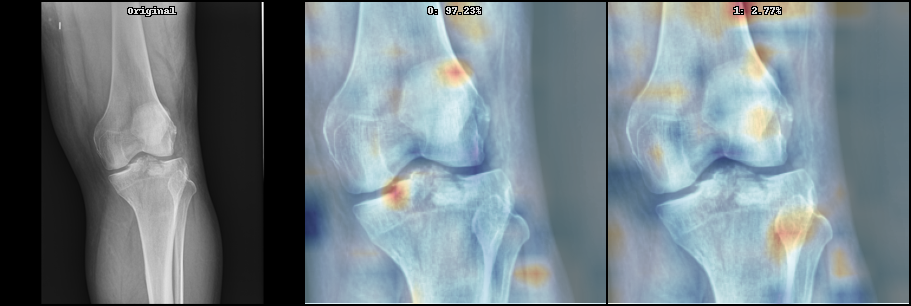

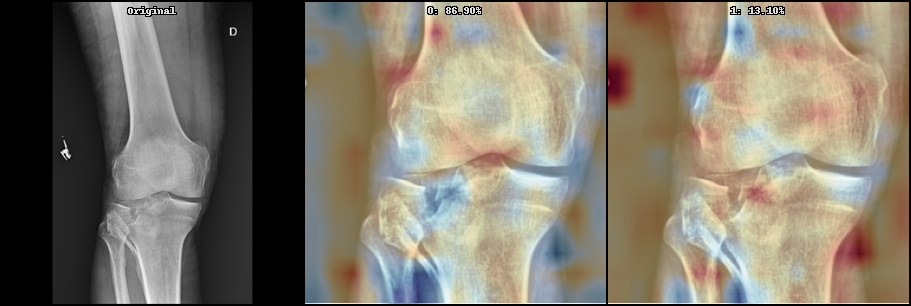

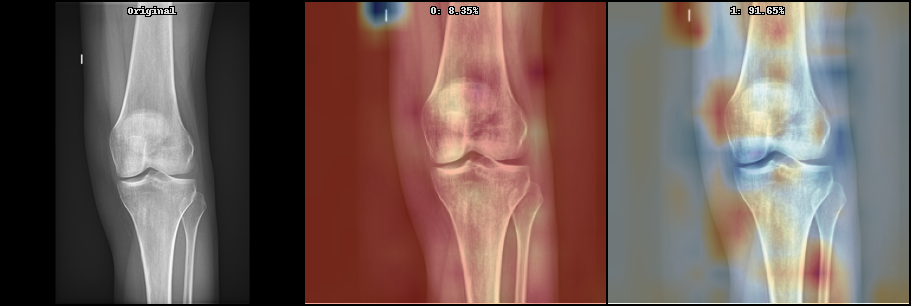

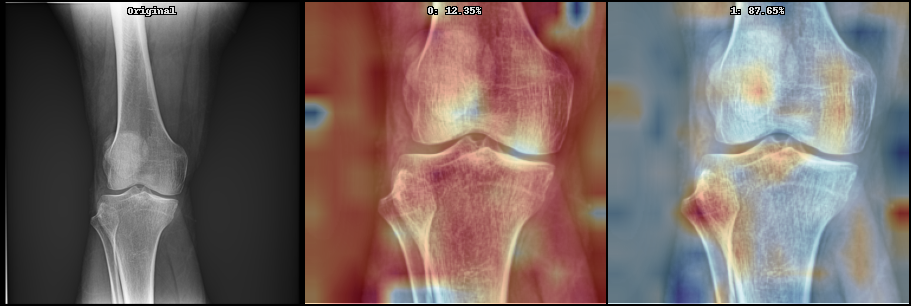

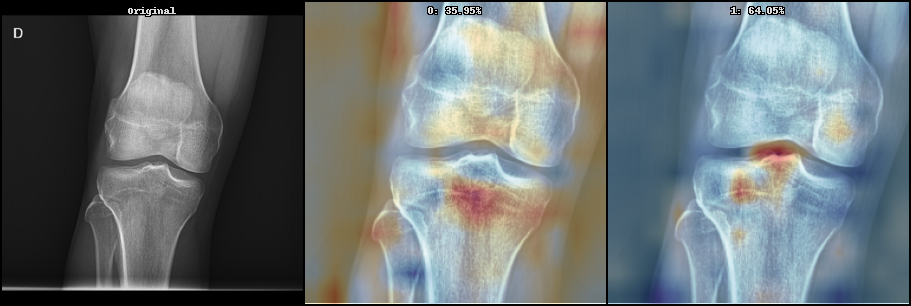

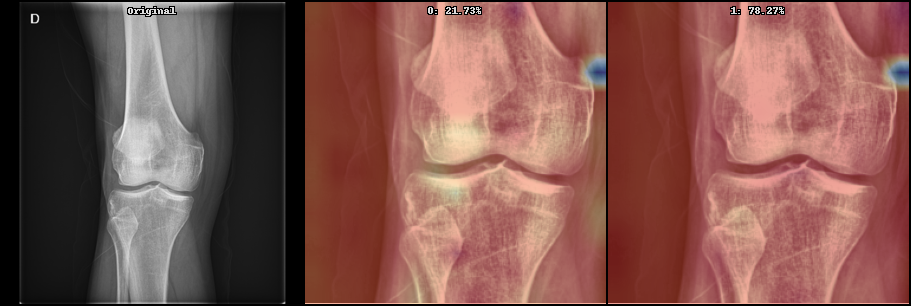

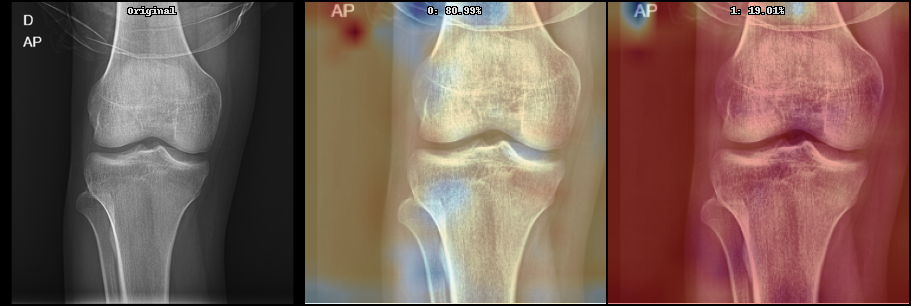

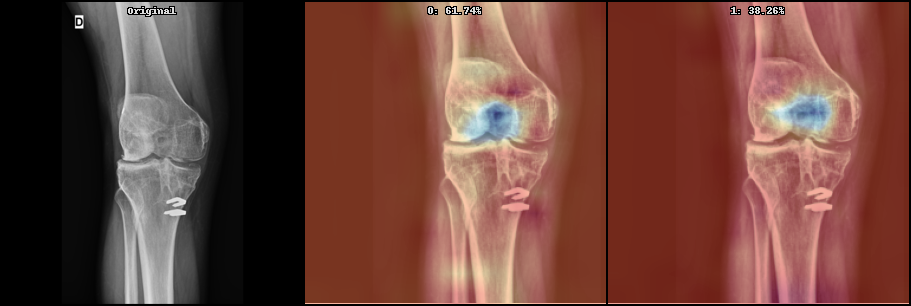

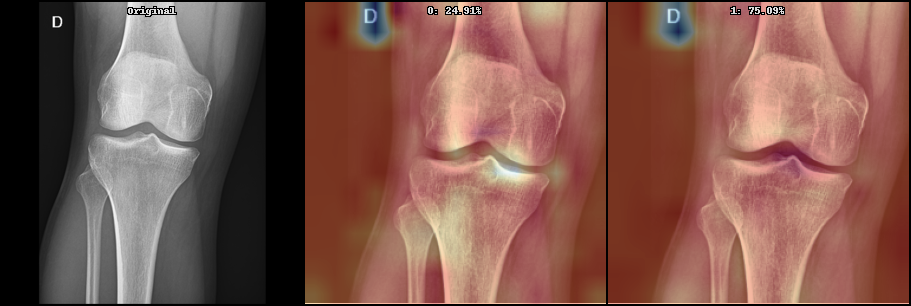

In [52]:
# Plot GradCAM for the top K images with largest loss

from fastai_amalgam.interpret.gradcam import gradcam

dls_idx = 1

for i in idx:
    gcam = gradcam(learn, learn.dls[dls_idx].items.iloc[i.numpy()]['Raw_preprocess'], labels=['0', '1'], show_original=True, cmap=plt.cm.bone)
    display(gcam)
    print()

/usr/local/lib/python3.6/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/usr/local/lib/python3.6/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn("Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked")


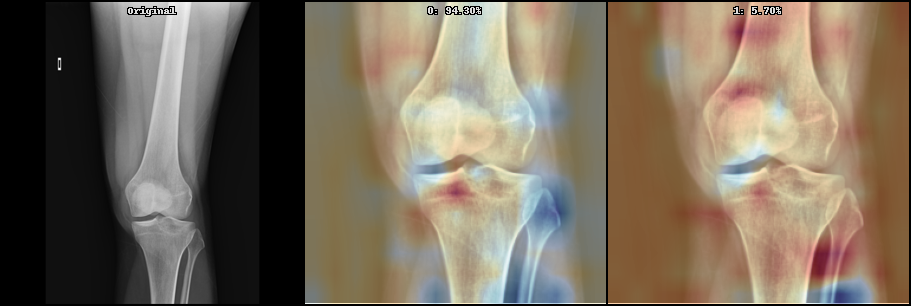

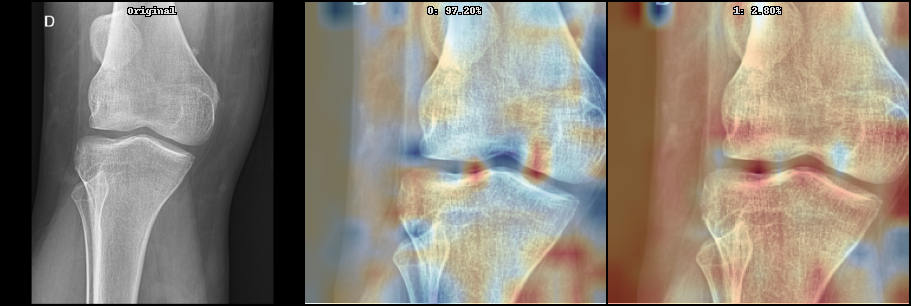

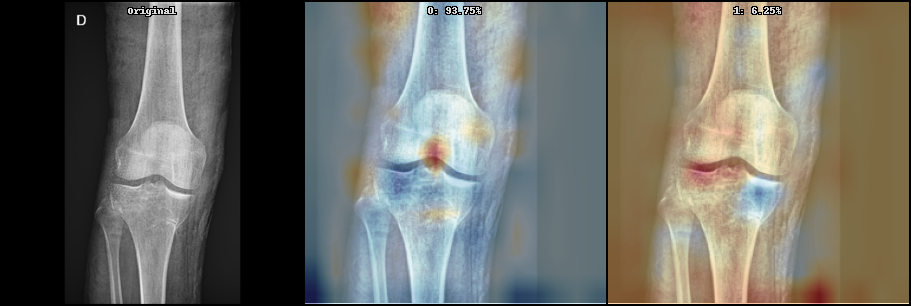

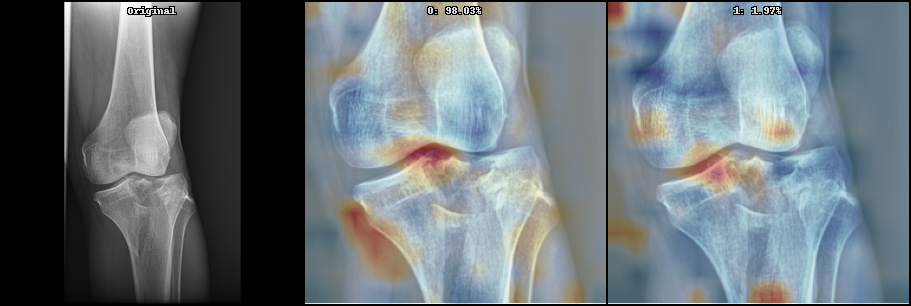

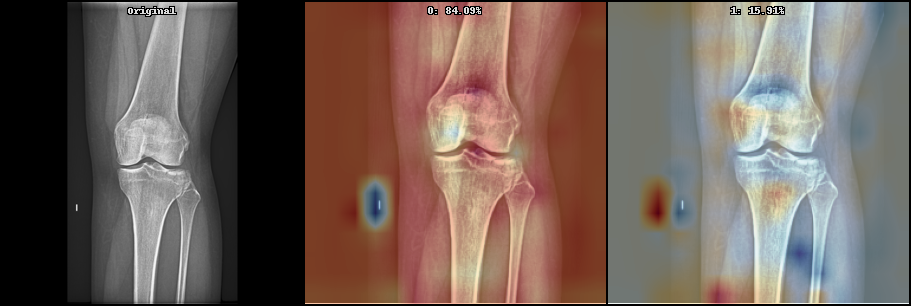

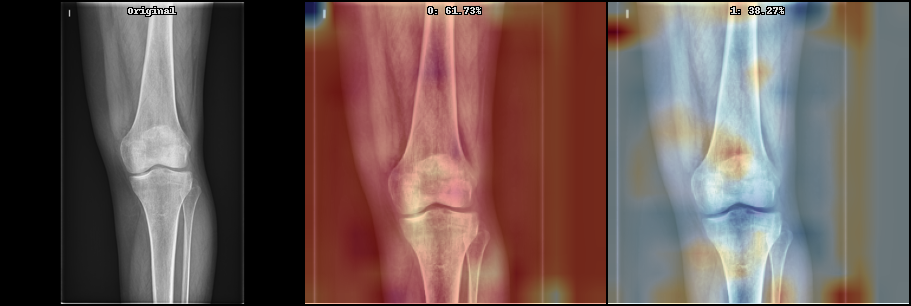

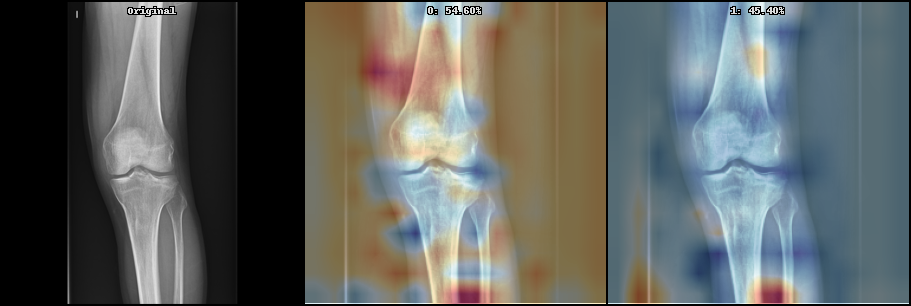

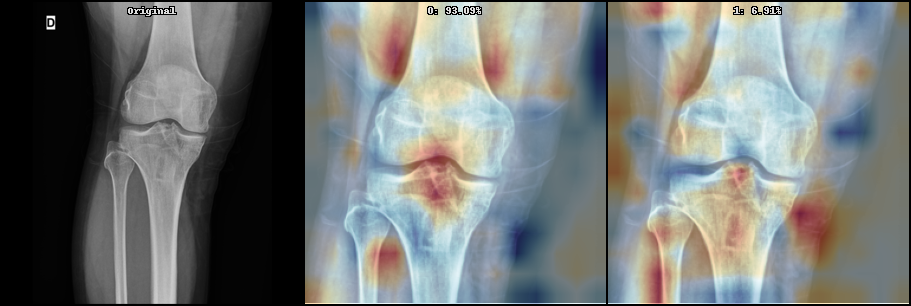

In [53]:
# Plot GradCAM for the true positive images

from fastai_amalgam.interpret.gradcam import gradcam

dls_idx = 0
label_idxs = learn.dls[dls_idx].items[learn.dls[dls_idx].items['Target'] != '0'].index

for i in label_idxs:
    gcam = gradcam(learn, learn.dls[dls_idx].items.loc[i, 'Raw_preprocess'], labels=['0', '1'], show_original=True, cmap=plt.cm.bone)
    display(gcam)
    print()

/usr/local/lib/python3.6/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/usr/local/lib/python3.6/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn("Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked")


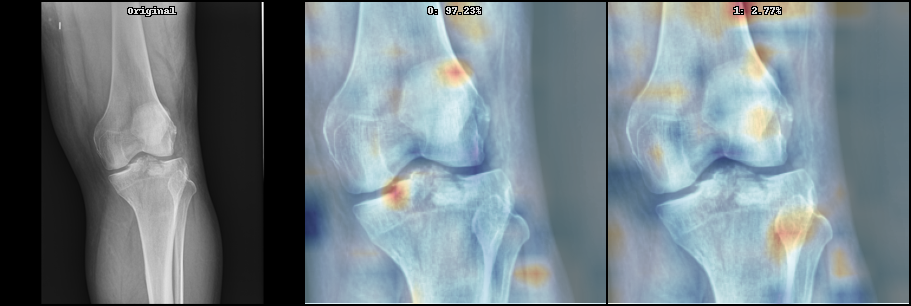

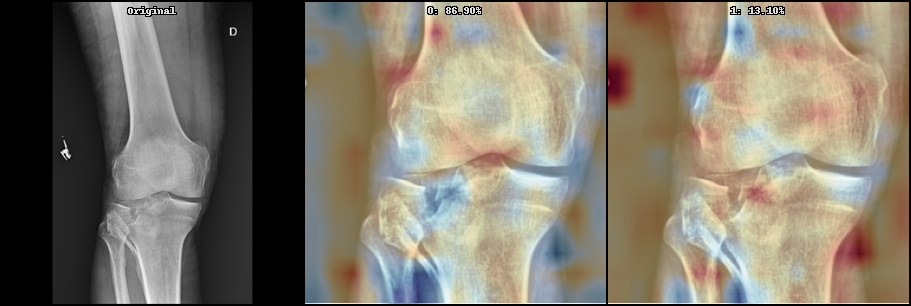

In [54]:
# Plot GradCAM for the true positive images

from fastai_amalgam.interpret.gradcam import gradcam

dls_idx = 1
label_idxs = learn.dls[dls_idx].items[learn.dls[dls_idx].items['Target'] != '0'].index

for i in label_idxs:
    gcam = gradcam(learn, learn.dls[dls_idx].items.loc[i, 'Raw_preprocess'], labels=['0', '1'], show_original=True, cmap=plt.cm.bone)
    display(gcam)
    print()

/usr/local/lib/python3.6/site-packages/fastai_amalgam/interpret/gradcam.py:65: UserWarning: Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened
  warnings.warn(f"Detected a pooling layer in the model body. Unless this is intentional, ensure that the feature map is not flattened")
/usr/local/lib/python3.6/site-packages/fastai_amalgam/utils.py:92: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked
  warnings.warn("Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked")


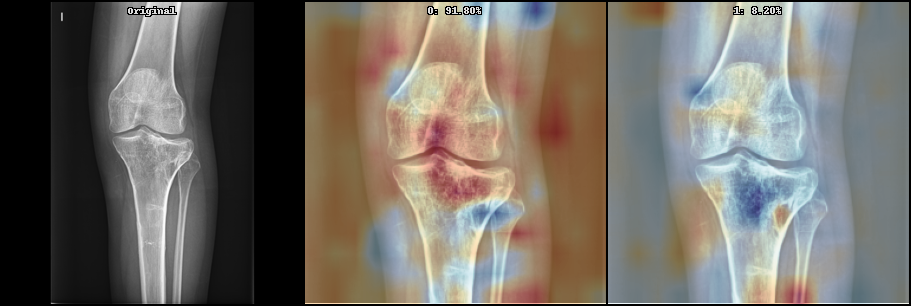

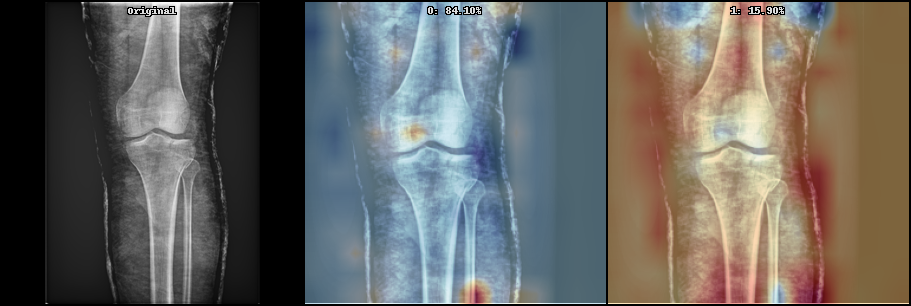

In [55]:
# Plot GradCAM for the true positive images

from fastai_amalgam.interpret.gradcam import gradcam

dls_idx = 2
label_idxs = learn.dls[dls_idx].items[learn.dls[dls_idx].items['Target'] != '0'].index

for i in label_idxs:
    gcam = gradcam(learn, learn.dls[dls_idx].items.loc[i, 'Raw_preprocess'], labels=['0', '1'], show_original=True, cmap=plt.cm.bone)
    display(gcam)
    print()